# Lab 05: Mask R-CNN and U-NET

NAME = "Todsavad Tangtortan"
ID = "123012"

### 1. Get the demo up and running.

In [ ]:
# !python3 train.py --use-cuda --iters 200 --dataset coco --data-dir /root/Datasets/coco --epochs 10

In [4]:
import torch
import pytorch_mask_rcnn as pmr

use_cuda = True
dataset = "coco"
# ckpt_path = "../ckpts/maskrcnn_voc-5.pth"
# data_dir = "E:/PyTorch/data/voc2012/"
ckpt_path = "maskrcnn_coco-10.pth"
data_dir = "/root/Datasets/coco"

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
if device.type == "cuda":
    pmr.get_gpu_prop(show=True)
print("\ndevice: {}".format(device))

ds = pmr.datasets(dataset, data_dir, "val2017", train=True)
#indices = torch.randperm(len(ds)).tolist()
#d = torch.utils.data.Subset(ds, indices)
d = torch.utils.data.DataLoader(ds, shuffle=True)

model = pmr.maskrcnn_resnet50(True, max(ds.classes) + 1).to(device)
model.eval()
model.head.score_thresh = 0.3

if ckpt_path:
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model"])
    print(checkpoint["eval_info"])
    del checkpoint
    
for p in model.parameters():
    p.requires_grad_(False)

cuda: True
available GPU(s): 4
0: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
1: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
2: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
3: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}

device: cuda
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 |

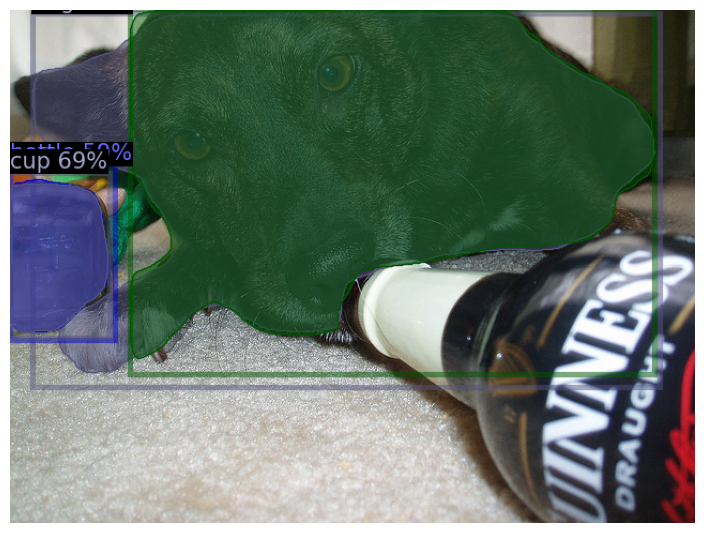

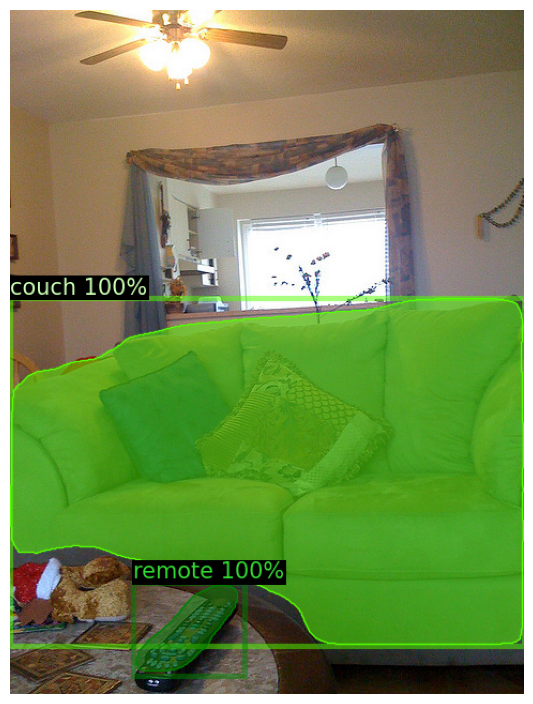

In [5]:
iters = 2

for i, (image, target) in enumerate(d):
    image = image.to(device)[0]
    #target = {k: v.to(device) for k, v in target.items()}
    
    with torch.no_grad():
        result = model(image)
    
    pmr.show(image, result, ds.classes, "./image/output{}.jpg".format(i))

    if i >= iters - 1:
        break

From the output, one can see that the model that was pretrained on COCO did a very good job at detecting the bbox and instance segmentations on validation image from COCO.

### 2. Evaluate the pretrained COCO model on the COCO validation set we used last week.

In [1]:
import argparse
import os
import time

import torch

import pytorch_mask_rcnn as pmr
    
def main(args):
    device = torch.device("cuda" if torch.cuda.is_available() and args.use_cuda else "cpu")
    cuda = device.type == "cuda"
    if cuda: pmr.get_gpu_prop(show=True)
    print("\ndevice: {}".format(device))
    
    d_test = pmr.datasets(args.dataset, args.data_dir, "val2017", train=True) # VOC 2012. set train=True for eval
    #d_test = pmr.datasets(args.dataset, args.data_dir, "val2017", train=True) # COCO 2017

    print(args)
    num_classes = max(d_test.classes) + 1
    model = pmr.maskrcnn_resnet50(False, num_classes).to(device)
    
    checkpoint = torch.load(args.ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model"])
    #print(checkpoint["eval_info"])
    del checkpoint
    if cuda: torch.cuda.empty_cache()

    print("\nevaluating...\n")
    
    B = time.time()
    eval_output, iter_eval = pmr.evaluate(model, d_test, device, args)
    B = time.time() - B
    
    print(eval_output.get_AP())
    if iter_eval is not None:
        print("\nTotal time of this evaluation: {:.1f} s, speed: {:.1f} imgs/s".format(B, 1 / iter_eval))
    
    
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset", default="coco")
    parser.add_argument("--data-dir", default="/root/Datasets/coco")
    parser.add_argument("--ckpt-path", default="/root/lab05/Simple-MaskRCNN/maskrcnn_coco-10.pth")
    parser.add_argument("--iters", type=int, default=3) # number of iterations, minus means the entire dataset
    args = parser.parse_args([]) # [] is needed if you're using Jupyter Notebook.
    
    args.use_cuda = True
    args.results = os.path.join(os.path.dirname(args.ckpt_path), "maskrcnn_results.pth")
    
    main(args)

cuda: True
available GPU(s): 4
0: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
1: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
2: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
3: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}

device: cuda
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
Namespace(ckpt_path='/root/lab05/Simple-MaskRCNN/maskrcnn_coco-10.pth', data_dir='/root/Datasets/coco', dataset='coco', iters=3, results='/root/lab05/Simple-MaskRCNN/maskrcnn_results.pth', use_cuda=True)

evaluating...



/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


iter: 150.0, total: 131.8, model: 105.2
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.07s).
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.06s).
accumulate: 0.2s
{'bbox AP': 24.9, 'mask AP': 21.0}

Total time of this evaluation: 4.5 s, speed: 6.7 imgs/s


mAP of 24.9 for bounding boxes and 21.0 for masks.

### 3. Download the Cityscapes dataset and run Mask R-CNN on it in inference model. Report your results and see what errors you find. [Link](https://www.cityscapes-dataset.com/)

In [ ]:
#Due to dataset doesn't provide annotatinos thus, I want to cityscape to coco format.
# python3 main.py --dataset cityscapes --datadir /root/Datasets/Cityscapes --outdir /root/Datasets/Cityscapes/annotations
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import sys

# Image processing
# Check if PIL is actually Pillow as expected
try:
    from PIL import __version__
except:
    print("Please install the module 'Pillow' for image processing, e.g.")
    print("pip install pillow")
    sys.exit(-1)

try:
    import PIL.Image     as Image
    import PIL.ImageDraw as ImageDraw
except:
    print("Failed to import the image processing packages.")
    sys.exit(-1)

import argparse
import json
import os
import cv2
import numpy as np

from utils.instance_class import *
from utils.labels import *

def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4
    Returns:
        contours, hierarchy
    """
    if cv2.__version__.startswith('4'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif cv2.__version__.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 3 or 4 to call this method')

    return contours, hierarchy

def instances2dict_with_polygons(imageFileList, verbose=False):
    imgCount     = 0
    instanceDict = {}

    if not isinstance(imageFileList, list):
        imageFileList = [imageFileList]

    if verbose:
        print("Processing {} images...".format(len(imageFileList)))

    for imageFileName in imageFileList:
        # Load image
        img = Image.open(imageFileName)

        # Image as numpy array
        imgNp = np.array(img)

        # Initialize label categories
        instances = {}
        for label in labels:
            instances[label.name] = []

        # Loop through all instance ids in instance image
        for instanceId in np.unique(imgNp):
            if instanceId < 1000:
                continue
            instanceObj = Instance(imgNp, instanceId)
            instanceObj_dict = instanceObj.toDict()

            if id2label[instanceObj.labelID].hasInstances:
                mask = (imgNp == instanceId).astype(np.uint8)
                contour, hier = findContours(
                    mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                polygons = [c.reshape(-1).tolist() for c in contour]
                instanceObj_dict['contours'] = polygons

            instances[id2label[instanceObj.labelID].name].append(instanceObj_dict)

        instanceDict[imageFileName] = instances
        imgCount += 1

        if verbose:
            print("\rImages Processed: {}".format(imgCount), end=' ')
            sys.stdout.flush()

    if verbose:
        print("")

    return instanceDict

def poly_to_box(poly):
    """Convert a polygon into a tight bounding box."""
    x0 = min(min(p[::2]) for p in poly)
    x1 = max(max(p[::2]) for p in poly)
    y0 = min(min(p[1::2]) for p in poly)
    y1 = max(max(p[1::2]) for p in poly)
    box_from_poly = [x0, y0, x1, y1]
    return box_from_poly

def xyxy_to_xywh(xyxy_box):
    xmin, ymin, xmax, ymax = xyxy_box
    TO_REMOVE = 1
    xywh_box = (xmin, ymin, xmax - xmin + TO_REMOVE, ymax - ymin + TO_REMOVE)
    return xywh_box

def convert_cityscapes_instance_only(data_dir, out_dir):
    """Convert from cityscapes format to COCO instance seg format - polygons"""
    sets = [
        'leftImg8bit/train',
        'leftImg8bit/val'
    ]

    ann_dirs = [
        'gtFine/train',
        'gtFine/val',
    ]

    json_name = 'instancesonly_filtered_%s.json'
    polygon_json_file_ending = '_polygons.json'
    img_id = 0
    ann_id = 0
    cat_id = 1
    category_dict = {}

    category_instancesonly = [
        'person',
        'rider',
        'car',
        'truck',
        'bus',
        'train',
        'motorcycle',
        'bicycle',
    ]

    for data_set, ann_dir in zip(sets, ann_dirs):
        print('Starting %s' % data_set)
        ann_dict = {}
        images = []
        annotations = []

        for root, _, files in os.walk(os.path.join(data_dir, ann_dir)):
            for filename in files:
                if filename.endswith(polygon_json_file_ending):

                    if len(images) % 50 == 0:
                        print("Processed %s images, %s annotations" % (len(images), len(annotations)))

                    json_ann = json.load(open(os.path.join(root, filename)))

                    image = {}
                    image['id'] = img_id
                    img_id += 1
                    image['width'] = json_ann['imgWidth']
                    image['height'] = json_ann['imgHeight']
                    image['file_name'] = os.path.join("leftImg8bit",
                                                      data_set.split("/")[-1],
                                                      filename.split('_')[0],
                                                      filename.replace("_gtFine_polygons.json", '_leftImg8bit.png'))
                    image['seg_file_name'] = filename.replace("_polygons.json", "_instanceIds.png")
                    images.append(image)

                    fullname = os.path.join(root, image['seg_file_name'])
                    objects = instances2dict_with_polygons([fullname], verbose=False)[fullname]

                    for object_cls in objects:
                        if object_cls not in category_instancesonly:
                            continue  # skip non-instance categories

                        for obj in objects[object_cls]:
                            if obj['contours'] == []:
                                print('Warning: empty contours.')
                                continue  # skip non-instance categories

                            len_p = [len(p) for p in obj['contours']]
                            if min(len_p) <= 4:
                                print('Warning: invalid contours.')
                                continue  # skip non-instance categories

                            ann = {}
                            ann['id'] = ann_id
                            ann_id += 1
                            ann['image_id'] = image['id']
                            ann['segmentation'] = obj['contours']

                            if object_cls not in category_dict:
                                category_dict[object_cls] = cat_id
                                cat_id += 1
                            ann['category_id'] = category_dict[object_cls]
                            ann['iscrowd'] = 0
                            ann['area'] = obj['pixelCount']

                            xyxy_box = poly_to_box(ann['segmentation'])
                            xywh_box = xyxy_to_xywh(xyxy_box)
                            ann['bbox'] = xywh_box

                            annotations.append(ann)

        ann_dict['images'] = images
        categories = [{"id": category_dict[name], "name": name} for name in category_dict]
        ann_dict['categories'] = categories
        ann_dict['annotations'] = annotations
        print("Num categories: %s" % len(categories))
        print("Num images: %s" % len(images))
        print("Num annotations: %s" % len(annotations))
        if not os.path.exists(os.path.abspath(out_dir)):
            os.mkdir(os.path.abspath(out_dir))
        with open(os.path.join(out_dir, json_name % ann_dir.replace("/", "_")), 'w') as outfile:
            outfile.write(json.dumps(ann_dict))


def parse_args():
    parser = argparse.ArgumentParser(description='Convert dataset')
    parser.add_argument('--dataset', help="cityscapes", default='cityscapes', type=str)
    parser.add_argument('--outdir', help="output dir for json files", default='data/cityscapes/annotations', type=str)
    parser.add_argument('--datadir', help="data dir for annotations to be converted", default="data/cityscapes", type=str)
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)
    return parser.parse_args()


if __name__ == '__main__':
    args = parse_args()
    if args.dataset == "cityscapes":
        convert_cityscapes_instance_only(args.datadir, args.outdir)
    else:
        print("Dataset not supported: %s" % args.dataset)

In [4]:
!python3 train.py --use-cuda --iters 200 --dataset cityscapes --data-dir /root/Datasets/Cityscapes --epochs 1

cuda: True
available GPU(s): 4
0: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
1: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
2: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}
3: {'name': 'NVIDIA GeForce RTX 2080 Ti', 'capability': [7, 5], 'total_momory': 10.76, 'sm_count': 68}

device: cuda:2
loading annotations into memory...
Done (t=1.10s)
creating index...
index created!
loading annotations into memory...
Done (t=1.49s)
creating index...
index created!
Namespace(ckpt_path='./models/city_maskrcnn_cityscapes.pth', data_dir='/root/Datasets/Cityscapes', dataset='cityscapes', device_num='2', epochs=1, iters=200, lr=0.00125, lr_steps=[6, 7], momentum=0.9, print_freq=100, results='./models/city_maskrcnn_results.pth', seed=3, use_cuda=True, warmup_iters=1000, weight_decay=0.0001)

already trained: 0 epochs; to 1 epochs

epoch: 1

In [20]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import utils
from coco_utils import get_coco
import transforms

device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device("cpu")
print("Configured device:", device)
# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load the COCO 2017 train and val sets. We use the CocoDetection class definition
# from ./coco_utils.py, not the original torchvision.CocoDetection class. Also, we
# use transforms from ./transforms, not torchvision.transforms, because they need
# to transform the bboxes and masks along with the image.

coco_path = "/root/Datasets/coco"

transform = transforms.Compose([
    transforms.ToTensor()
])

print('Loading COCO train, val datasets...')
coco_train_dataset = get_coco(coco_path, 'train', transform)
coco_val_dataset = get_coco(coco_path, 'val', transform)

def collate_fn(batch):
    return tuple(zip(*batch))

val_dataloader = DataLoader(coco_val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)

Configured device: cuda:3
Loading pretrained model...
Loading COCO train, val datasets...
loading annotations into memory...
Done (t=36.84s)
creating index...
index created!
loading annotations into memory...
Done (t=6.25s)
creating index...
index created!


In [21]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
images, targets = next(iter(val_dataloader))

print(type(images), len(images))
print(images[0].shape)
print(type(targets), len(targets))
print(targets[0].keys())
# print()
# images = images.to(device)

images = [ img.to(device) for img in images ]
predictions = model(images)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

In [ ]:
# !pip install opencv-python
# !apt-get update
# !apt install libgl1-mesa-glx
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

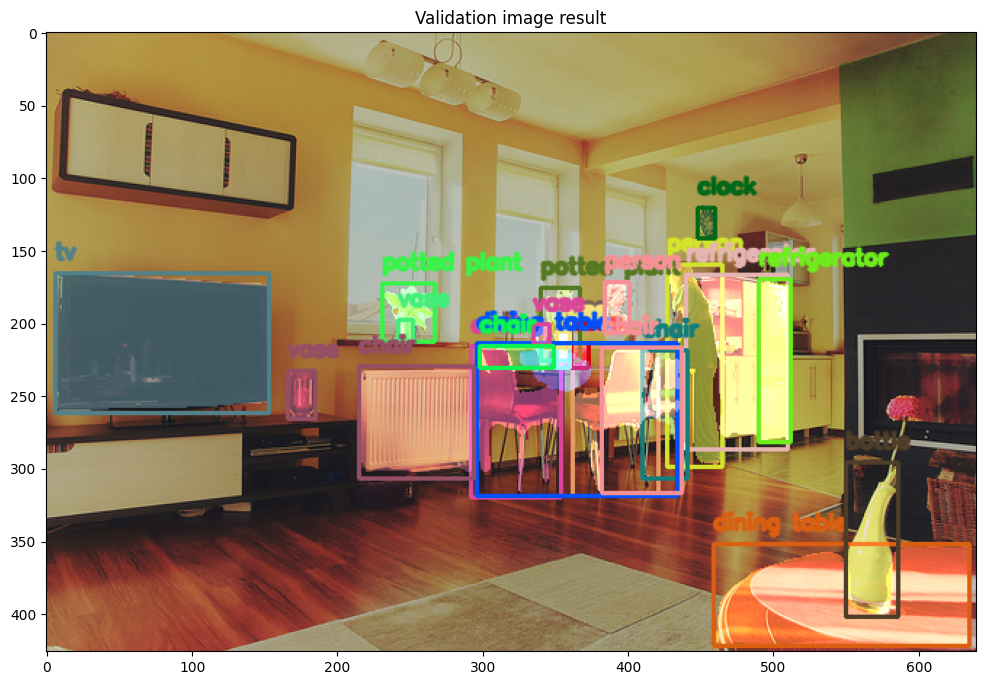

In [ ]:
from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

In [ ]:
from engine import evaluate
results = evaluate(model, val_dataloader, device)

Test:  [   0/1250]  eta: 2:07:42  model_time: 0.7071 (0.7071)  evaluator_time: 0.5517 (0.5517)  time: 6.1303  data: 0.4237  max mem: 0
Test:  [ 100/1250]  eta: 0:26:33  model_time: 0.4792 (0.4967)  evaluator_time: 0.1888 (0.2832)  time: 1.5557  data: 0.8048  max mem: 0
Test:  [ 200/1250]  eta: 0:23:32  model_time: 0.4807 (0.5005)  evaluator_time: 0.2576 (0.2742)  time: 1.1708  data: 0.4154  max mem: 0
Test:  [ 300/1250]  eta: 0:20:56  model_time: 0.5056 (0.4965)  evaluator_time: 0.2880 (0.2662)  time: 1.4042  data: 0.5783  max mem: 0
Test:  [ 400/1250]  eta: 0:18:43  model_time: 0.5572 (0.4975)  evaluator_time: 0.2891 (0.2657)  time: 1.4700  data: 0.5940  max mem: 0
Test:  [ 500/1250]  eta: 0:16:30  model_time: 0.4536 (0.4912)  evaluator_time: 0.2300 (0.2582)  time: 1.3308  data: 0.6276  max mem: 0
Test:  [ 600/1250]  eta: 0:14:20  model_time: 0.4918 (0.4881)  evaluator_time: 0.2215 (0.2567)  time: 1.2673  data: 0.5862  max mem: 0
Test:  [ 700/1250]  eta: 0:12:10  model_time: 0.4802 (0

### 4. Fine tune the COCO Mask R-CNN on Cityscapes and report the results. Are they close to what's reported in the Mask R-CNN paper?

### 5. Try U-NET and compare with Mask R-CNN

In [2]:
!python3 unet_train.py

Dataset CityscapesDataset
    Number of images: 2975
    Split: train
    Mode: gtFine
    Augment: True
    Root Location: /root/Datasets/Cityscapes/

creating unet model...
- model restored from file....
- filename = ./unet.pt
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:404: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
epoch = 0 | loss = 0.5206875801086426
epoch = 0 | loss = 0.5036841034889221
^C
Traceback (most recent call last):
  File "unet_train.py", line 68, in <module>
    for idx_batch, (imagergb, labelmask, labelrgb) in enumerate(img_batch):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 561, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File